# Exploratory Data Analysis

This notebook produces visual analyses. Each figure shows:
- The distribution of `Depression Level` across demographic groups
- The distributions / correlations for Stress, Anxiety and Depression factors

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os

BASE_DIR = Path.cwd().parents[1]
DATA_PATH = BASE_DIR / "data" / "processed" / "tabular" / "mhp_processed_tabular.csv"
df = pd.read_csv(DATA_PATH)

df['Depression Label'] = df['Depression Label'].astype('category')

deplvl_order = ["Minimal", "Mild", "Moderate", "Moderately Severe", "Severe"]

pss_cols = [f"PSS{i+1}" for i in range(10)]
gad_cols = [f"GAD{i+1}" for i in range(7)]
phq_cols = [f"PHQ{i+1}" for i in range(9)]

sns.set(style="whitegrid")
plt.rcParams.update({"figure.dpi": 120})

FIG_DIR = BASE_DIR / "figures" / "Exploratory Data Analysis"
FIG_DIR.mkdir(parents=True, exist_ok=True)
FIG_FORMAT = "png"

def save_fig(fig, name):
    path = FIG_DIR / f"{name}.{FIG_FORMAT}"
    fig.savefig(path, format=FIG_FORMAT, bbox_inches="tight", dpi=300)
    print(f"✅ Figure saved: {path.resolve()}")

## Distribution of Depression Level across Age

C:\Users\ryo\AppData\Local\Temp\ipykernel_2324\4276666557.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_dep = df.groupby(["AgeGroup", "Depression Label"]).size().unstack(fill_value=0)[deplvl_order]


✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\distribution_depression_age.png


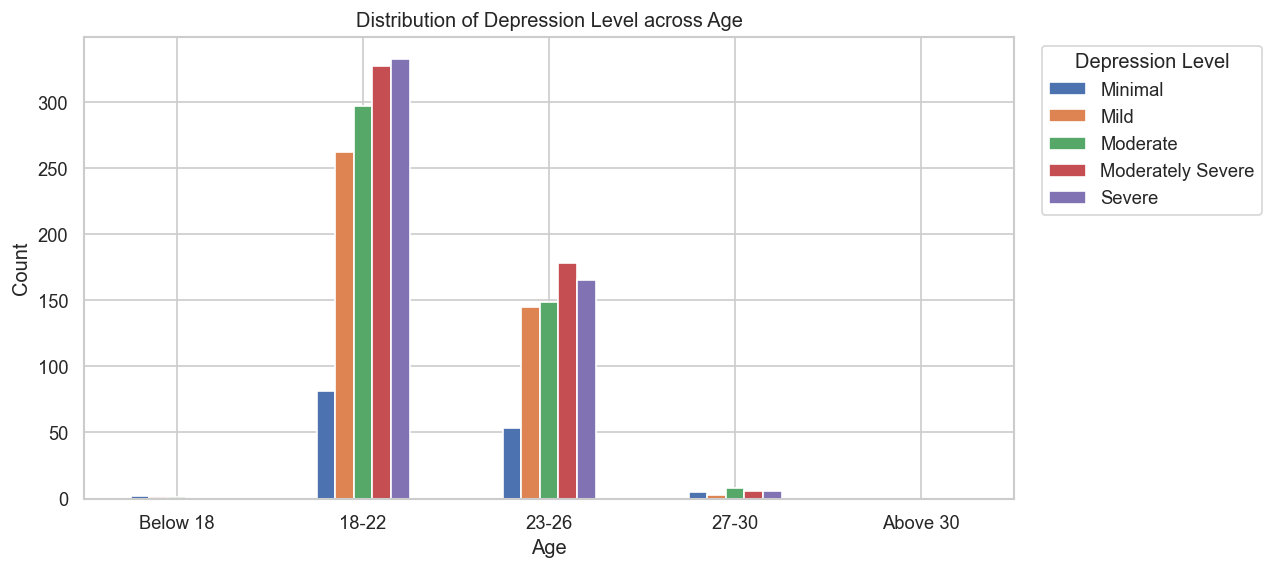

In [2]:
age_col = "Age"
def make_age_cat(val):
    try:
        a = float(val)
        if a < 18: return "Below 18"
        if 18 <= a <= 22: return "18-22"
        if 23 <= a <= 26: return "23-26"
        if 27 <= a <= 30: return "27-30"
        return "Above 30"
    except:
        s = str(val)
        if "Below" in s or "<18" in s: return "Below 18"
        if "18" in s and "22" in s: return "18-22"
        if "23" in s and "26" in s: return "23-26"
        if "27" in s and "30" in s: return "27-30"
        try:
            num = int(''.join(ch for ch in s if ch.isdigit())[:2])
            return make_age_cat(num)
        except:
            return "Above 30"

df["AgeGroup"] = df[age_col].apply(make_age_cat).astype("category")
age_order = ["Below 18", "18-22", "23-26", "27-30", "Above 30"]
df["AgeGroup"] = pd.Categorical(df["AgeGroup"], categories=age_order, ordered=True)

age_dep = df.groupby(["AgeGroup", "Depression Label"]).size().unstack(fill_value=0)[deplvl_order]

fig, ax = plt.subplots(figsize=(10,5))
age_dep.plot(kind="bar", stacked=False, ax=ax)
ax.set_xlabel("Age")
ax.set_ylabel("Count")
ax.set_title("Distribution of Depression Level across Age")
ax.legend(title="Depression Level", bbox_to_anchor=(1.02,1), loc="upper left")
plt.xticks(rotation=0)
save_fig(fig, "distribution_depression_age")
plt.show()

## Gender Distribution among Respondents

✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\gender_distribution.png


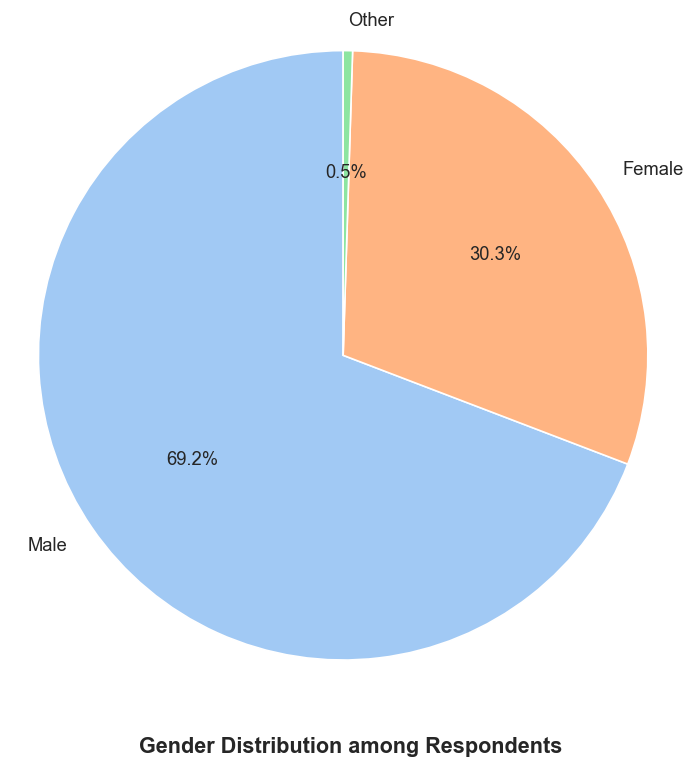

In [3]:
df["Gender"] = df["Gender"].astype(str).str.title().replace({"Prefer Not To Say": "Other"})

gender_counts = df["Gender"].value_counts().reindex(["Male", "Female", "Other"]).fillna(0)

fig, ax = plt.subplots(figsize=(6, 6))
colors = sns.color_palette("pastel")[0:3]

wedges, texts, autotexts = ax.pie(
    gender_counts,
    labels=gender_counts.index,
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    textprops={"fontsize": 11},
)
ax.axis("equal")

fig.text(
    0.5, -0.05, "Gender Distribution among Respondents",
    ha="center", va="center", fontsize=13, fontweight="bold"
)

plt.tight_layout()
save_fig(fig, "gender_distribution")
plt.show()

## Distribution of Depression Level across Gender

✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\distribution_depression_gender.png


C:\Users\ryo\AppData\Local\Temp\ipykernel_2324\1616158097.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_dep = df.groupby(["Depression Label", "Gender"]).size().unstack(fill_value=0).reindex(deplvl_order)


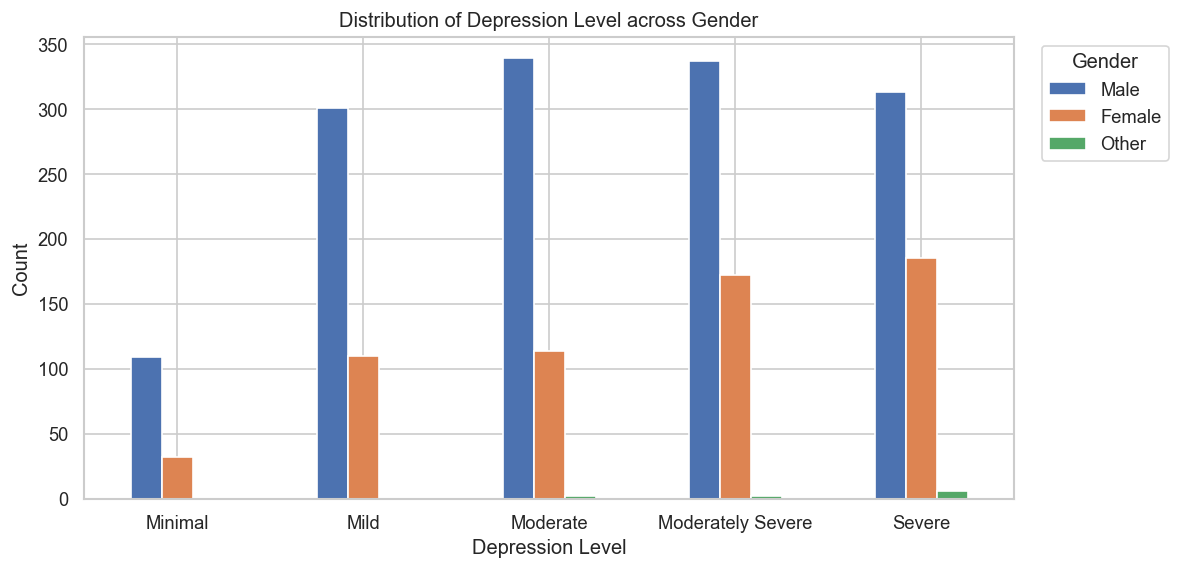

In [4]:
df["Gender"] = df["Gender"].astype(str).str.title().replace({"Prefer Not To Say":"Other"})
gender_order = ["Male","Female","Other"]

gender_dep = df.groupby(["Depression Label", "Gender"]).size().unstack(fill_value=0).reindex(deplvl_order)

fig, ax = plt.subplots(figsize=(10,5))
gender_dep[gender_order].plot(kind="bar", ax=ax)
ax.set_xlabel("Depression Level")
ax.set_ylabel("Count")
ax.set_title("Distribution of Depression Level across Gender")
ax.legend(title="Gender", bbox_to_anchor=(1.02,1), loc="upper left")
plt.xticks(rotation=0)
save_fig(fig, "distribution_depression_gender")
plt.show()

## Distribution of Depression Level across Top 6 University Correspondents

C:\Users\ryo\AppData\Local\Temp\ipykernel_2324\3263660180.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  uni_dep = uni_df.groupby(["University","Depression Label"]).size().unstack(fill_value=0).reindex(columns=deplvl_order)


✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\distribution_depression_university.png


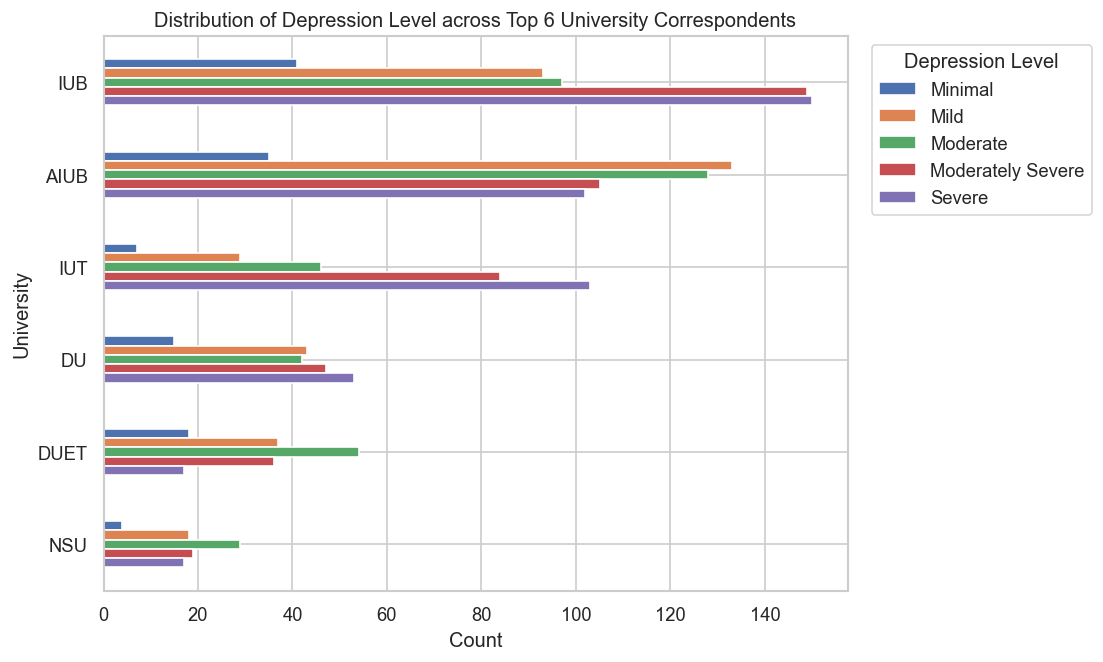

In [5]:
top6_unis = df["University"].value_counts().nlargest(6).index.tolist()
uni_df = df[df["University"].isin(top6_unis)]
uni_dep = uni_df.groupby(["University","Depression Label"]).size().unstack(fill_value=0).reindex(columns=deplvl_order)

uni_dep = uni_dep.loc[top6_unis]

fig, ax = plt.subplots(figsize=(8,6))
uni_dep.plot(kind="barh", stacked=False, ax=ax)
ax.set_ylabel("University")
ax.set_xlabel("Count")
ax.set_title("Distribution of Depression Level across Top 6 University Correspondents")
ax.legend(title="Depression Level", bbox_to_anchor=(1.02,1), loc="upper left")
plt.gca().invert_yaxis()
save_fig(fig, "distribution_depression_university")
plt.show()

## Distribution of Depression Level across Departments

C:\Users\ryo\AppData\Local\Temp\ipykernel_2324\1967730347.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dept_dep = df.groupby(["DeptDisplay","Depression Label"]).size().unstack(fill_value=0).reindex(dept_order)


✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\distribution_depression_department.png


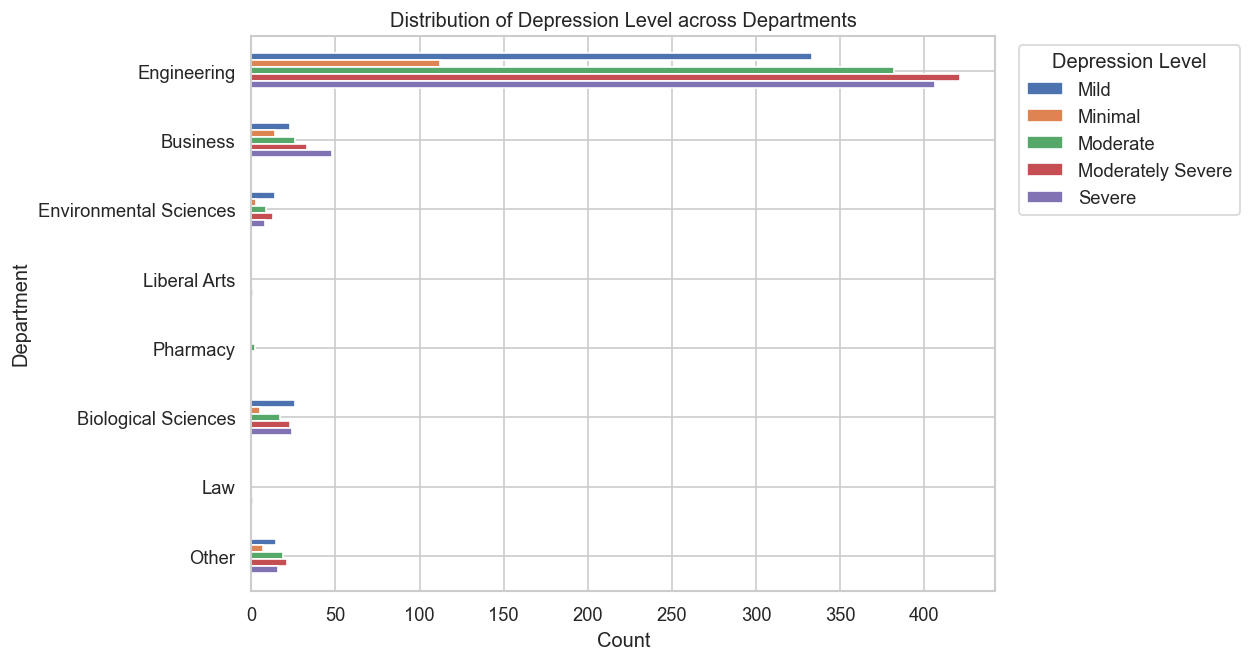

In [6]:
dept_map = {
    "Engineering":"Engineering",
    "Business":"Business",
    "Environmental":"Environmental Sciences",
    "Liberal":"Liberal Arts",
    "Pharmacy":"Pharmacy",
    "Biological":"Biological Sciences",
    "Law":"Law"
}

def map_dept(x):
    s = str(x).strip()
    for k in dept_map:
        if s.lower().startswith(k.lower()):
            return dept_map[k]
    return "Other"

df["DeptDisplay"] = df["Department"].apply(map_dept)
dept_order = ["Engineering","Business","Environmental Sciences","Liberal Arts","Pharmacy","Biological Sciences","Law","Other"]

dept_dep = df.groupby(["DeptDisplay","Depression Label"]).size().unstack(fill_value=0).reindex(dept_order)

fig, ax = plt.subplots(figsize=(8,6))
dept_dep.plot(kind="barh", stacked=False, ax=ax)
ax.set_ylabel("Department")
ax.set_xlabel("Count")
ax.set_title("Distribution of Depression Level across Departments")
ax.legend(title="Depression Level", bbox_to_anchor=(1.02,1), loc="upper left")
plt.gca().invert_yaxis()
save_fig(fig, "distribution_depression_department")
plt.show()

## Distribution of Depression Level across Academic years

C:\Users\ryo\AppData\Local\Temp\ipykernel_2324\4154512832.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  year_dep = df.groupby(["YearDisplay","Depression Label"]).size().unstack(fill_value=0).reindex(year_order)


✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\distribution_depression_academic_year.png


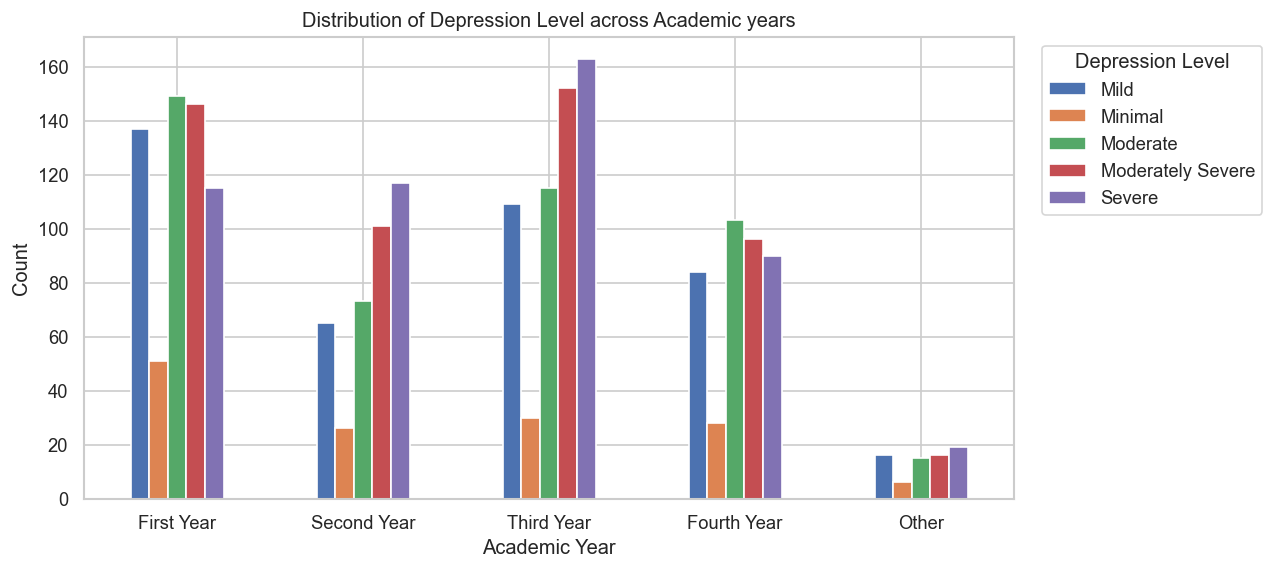

In [7]:
yr_map = {"First":"First Year", "Second":"Second Year", "Third":"Third Year", "Fourth":"Fourth Year"}
def map_year(x):
    s = str(x).strip().split()[0].title()
    return yr_map.get(s, "Other")

df["YearDisplay"] = df["Year"].apply(map_year)
year_order = ["First Year","Second Year","Third Year","Fourth Year","Other"]

year_dep = df.groupby(["YearDisplay","Depression Label"]).size().unstack(fill_value=0).reindex(year_order)

fig, ax = plt.subplots(figsize=(10,5))
year_dep.plot(kind="bar", stacked=False, ax=ax)
ax.set_xlabel("Academic Year")
ax.set_ylabel("Count")
ax.set_title("Distribution of Depression Level across Academic years")
ax.legend(title="Depression Level", bbox_to_anchor=(1.02,1), loc="upper left")
plt.xticks(rotation=0)
save_fig(fig, "distribution_depression_academic_year")
plt.show()

## Distribution of Depression Level across Current CGPA

CGPAGroup value counts (in plotting order):
CGPAGroup
Below 2.50      83
2.50 - 2.99    389
3.00 - 3.39    580
3.40 - 3.79    558
3.80 - 4.00    241
Other          171
Name: count, dtype: int64
✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\distribution_depression_cgpa.png


C:\Users\ryo\AppData\Local\Temp\ipykernel_2324\2421412304.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cgpa_dep = df.groupby(["CGPAGroup","Depression Label"]).size().unstack(fill_value=0).reindex(cgpa_order)


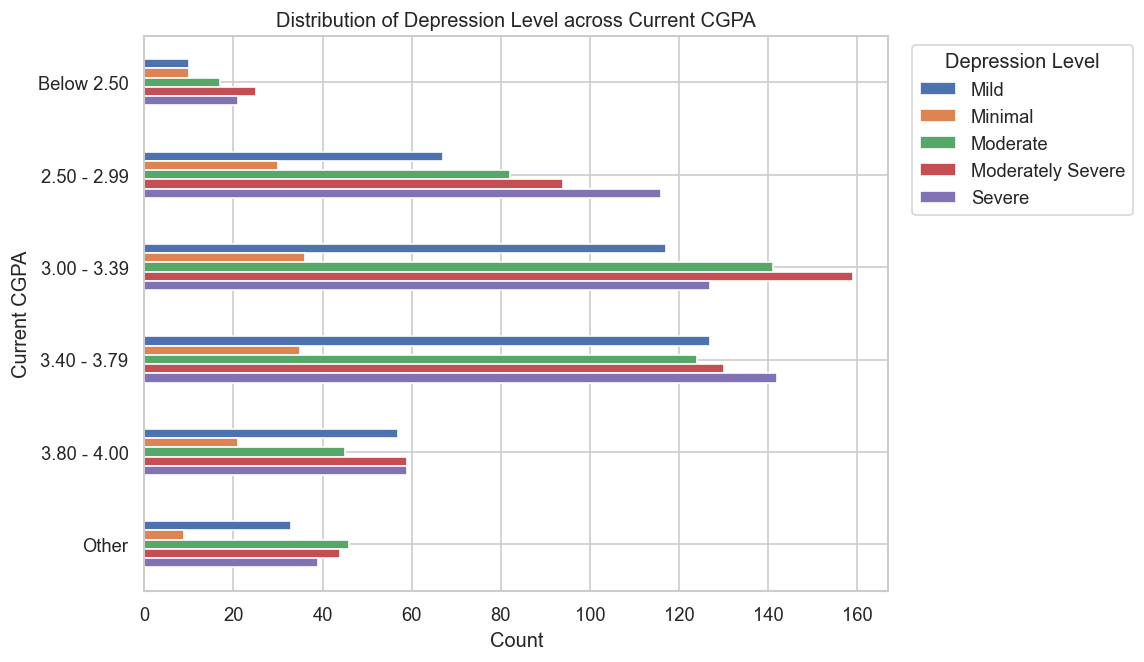

In [8]:
known_cats = ["Below 2.50", "2.50 - 2.99", "3.00 - 3.39", "3.40 - 3.79", "3.80 - 4.00"]

def map_cgpa_fixed(val):
    if pd.isna(val):
        return "Other"
    s = str(val).strip()
    if s in known_cats:
        return s
    for cat in known_cats:
        if s.replace(" ", "").lower() == cat.replace(" ", "").lower():
            return cat
    try:
        v = float(s)
        if v < 2.5:
            return "Below 2.50"
        if 2.5 <= v < 3.0:
            return "2.50 - 2.99"
        if 3.0 <= v < 3.4:
            return "3.00 - 3.39"
        if 3.4 <= v < 3.8:
            return "3.40 - 3.79"
        if 3.8 <= v <= 4.0:
            return "3.80 - 4.00"
        return "Other"
    except:
        if "-" in s and any(part.strip().replace(".","").isdigit() for part in s.split("-")):
            left = s.split("-")[0].strip()
            if "Below" in left or "<2.5" in left:
                return "Below 2.50"
            try:
                num = float(''.join(ch for ch in left if (ch.isdigit() or ch=='.')))
                return map_cgpa_fixed(num)
            except:
                return "Other"
        return "Other"

df["CGPAGroup"] = df["CGPA"].apply(map_cgpa_fixed).astype("category")
cgpa_order = ["Below 2.50","2.50 - 2.99","3.00 - 3.39","3.40 - 3.79","3.80 - 4.00","Other"]
df["CGPAGroup"] = pd.Categorical(df["CGPAGroup"], categories=cgpa_order, ordered=True)

print("CGPAGroup value counts (in plotting order):")
print(df["CGPAGroup"].value_counts().reindex(cgpa_order).fillna(0))

cgpa_dep = df.groupby(["CGPAGroup","Depression Label"]).size().unstack(fill_value=0).reindex(cgpa_order)

fig, ax = plt.subplots(figsize=(8,6))
cgpa_dep.plot(kind="barh", stacked=False, ax=ax)
ax.set_ylabel("Current CGPA")
ax.set_xlabel("Count")
ax.set_title("Distribution of Depression Level across Current CGPA")
ax.legend(title="Depression Level", bbox_to_anchor=(1.02,1), loc="upper left")
plt.gca().invert_yaxis()
save_fig(fig, "distribution_depression_cgpa")
plt.show()

## Distribution of Depression Level across Receiving Waiver/Scholarship

✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\distribution_depression_scholarship.png


C:\Users\ryo\AppData\Local\Temp\ipykernel_2324\4235403795.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sch_dep = df.groupby(["Depression Label","Scholarship"]).size().unstack(fill_value=0).reindex(deplvl_order)


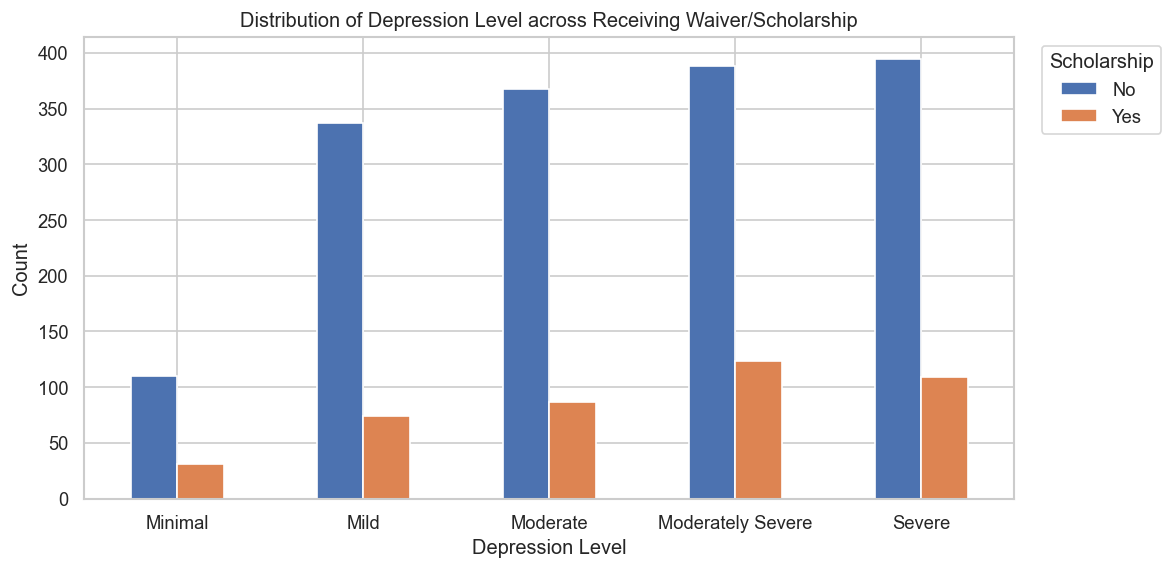

In [9]:
df["Scholarship"] = df["Scholarship"].astype(str).str.title().replace({"Yes,":"Yes","No,":"No"})
sch_dep = df.groupby(["Depression Label","Scholarship"]).size().unstack(fill_value=0).reindex(deplvl_order)

fig, ax = plt.subplots(figsize=(10,5))
sch_dep.plot(kind="bar", ax=ax)
ax.set_xlabel("Depression Level")
ax.set_ylabel("Count")
ax.set_title("Distribution of Depression Level across Receiving Waiver/Scholarship")
ax.legend(title="Scholarship", bbox_to_anchor=(1.02,1), loc="upper left")
plt.xticks(rotation=0)
save_fig(fig, "distribution_depression_scholarship")
plt.show()

## Correlation among Stress Factors

✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\correlation_pss_stress.png


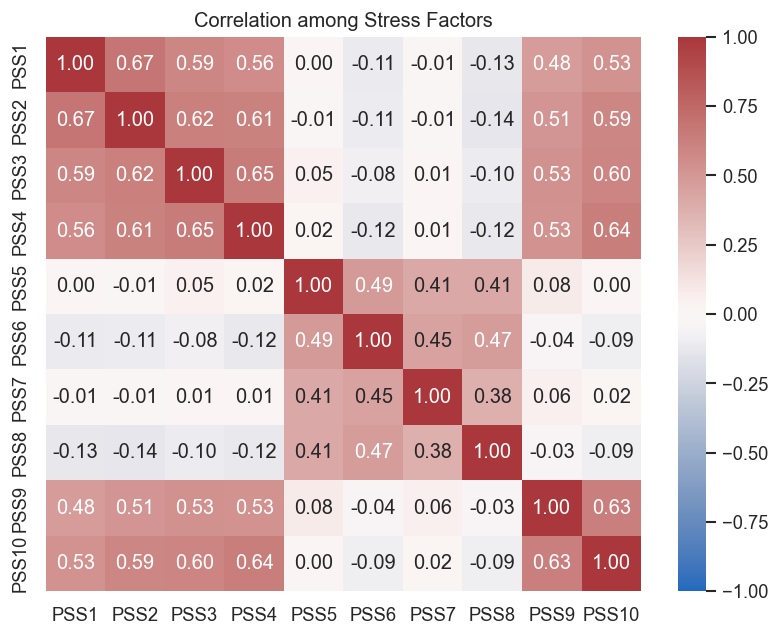

In [10]:
pss_corr = df[pss_cols].corr()
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(pss_corr, annot=True, fmt=".2f", cmap="vlag", ax=ax, vmin=-1, vmax=1)
ax.set_title("Correlation among Stress Factors")
save_fig(fig, "correlation_pss_stress")
plt.show()

## Correlation among Anxiety Factors

✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\correlation_gad_anxiety.png


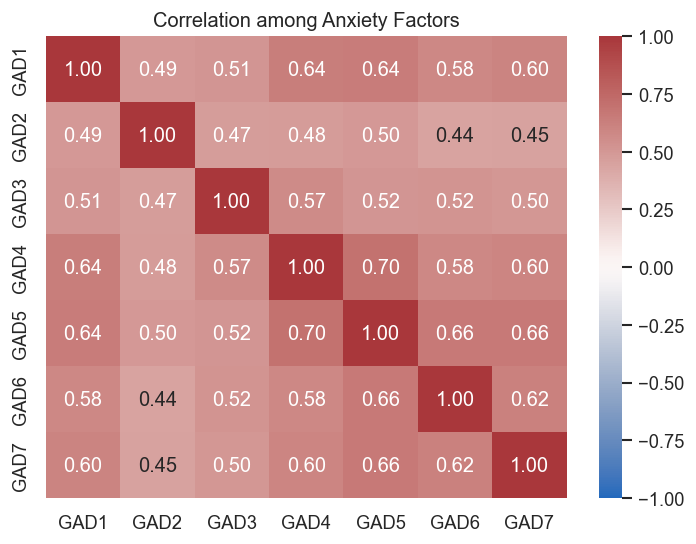

In [11]:
gad_corr = df[gad_cols].corr()
fig, ax = plt.subplots(figsize=(7,5))
sns.heatmap(gad_corr, annot=True, fmt=".2f", cmap="vlag", ax=ax, vmin=-1, vmax=1)
ax.set_title("Correlation among Anxiety Factors")
save_fig(fig, "correlation_gad_anxiety")
plt.show()

## Correlation among Depression Factors

✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\correlation_phq_depression.png


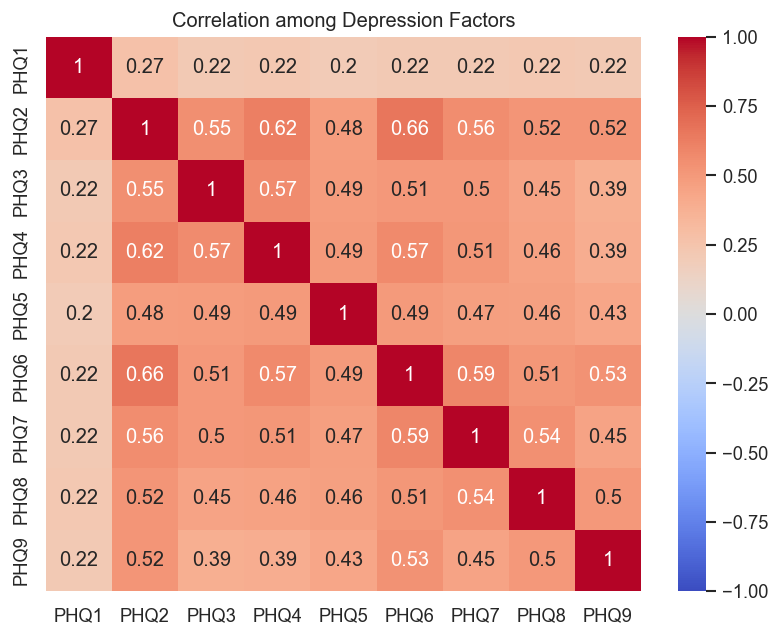

In [12]:
phq_corr = df[[f"PHQ{i+1}" for i in range(9)]].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(phq_corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
ax.set_title("Correlation among Depression Factors")
save_fig(fig, "correlation_phq_depression")
plt.show()

## Correlation among Stress, Anxiety, and Depression Factors

✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\correlation_stress_anxiety_depression.png


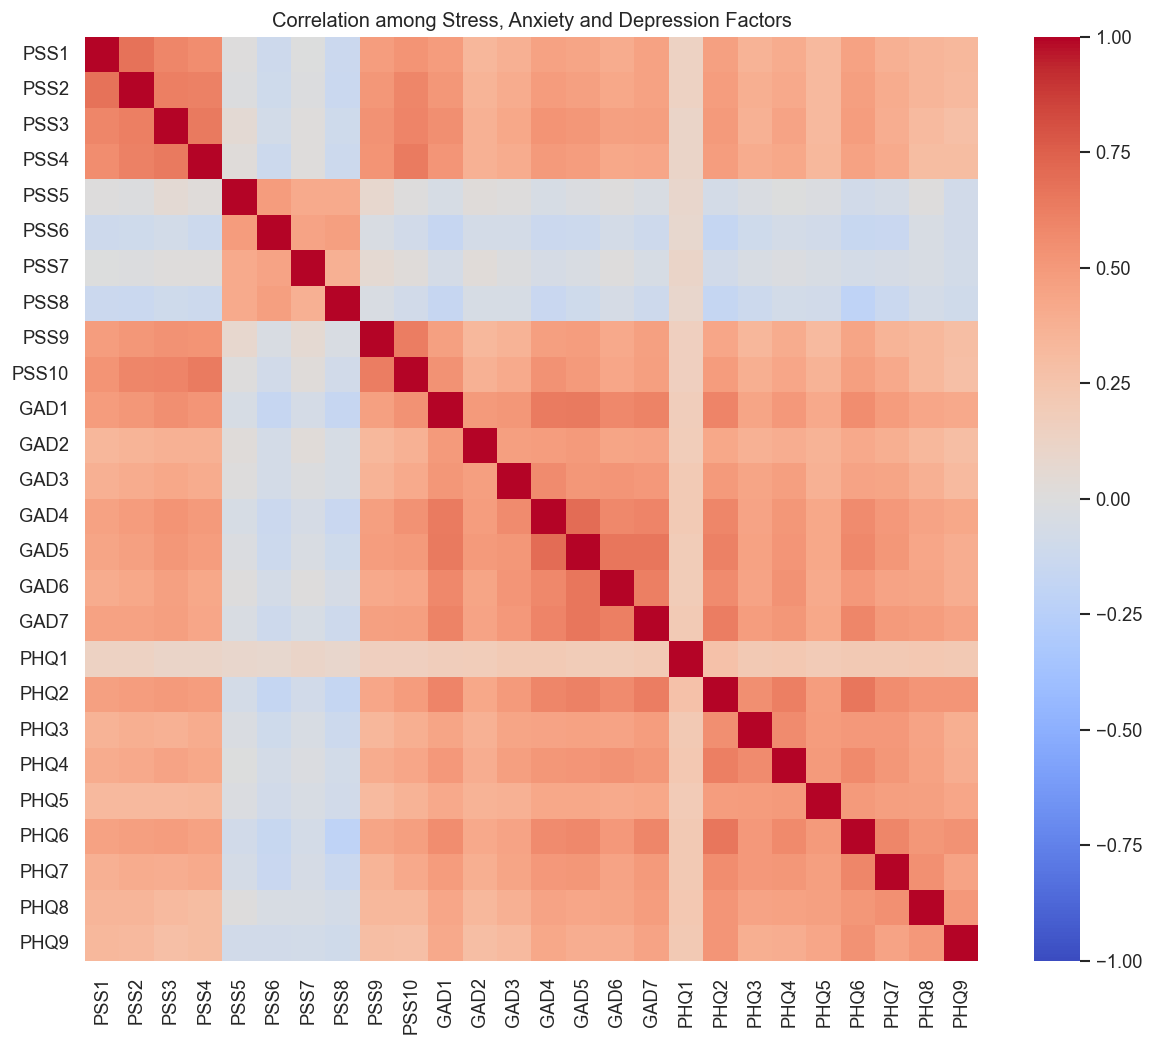

In [13]:
all_scales = [f"PSS{i+1}" for i in range(10)] + [f"GAD{i+1}" for i in range(7)] + [f"PHQ{i+1}" for i in range(9)]
corr_all = df[all_scales].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_all, cmap="coolwarm", vmin=-1, vmax=1, ax=ax)
ax.set_title("Correlation among Stress, Anxiety and Depression Factors")
save_fig(fig, "correlation_stress_anxiety_depression")
plt.show()

## Responses on Stress Factors

✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\responses_pss_stress.png


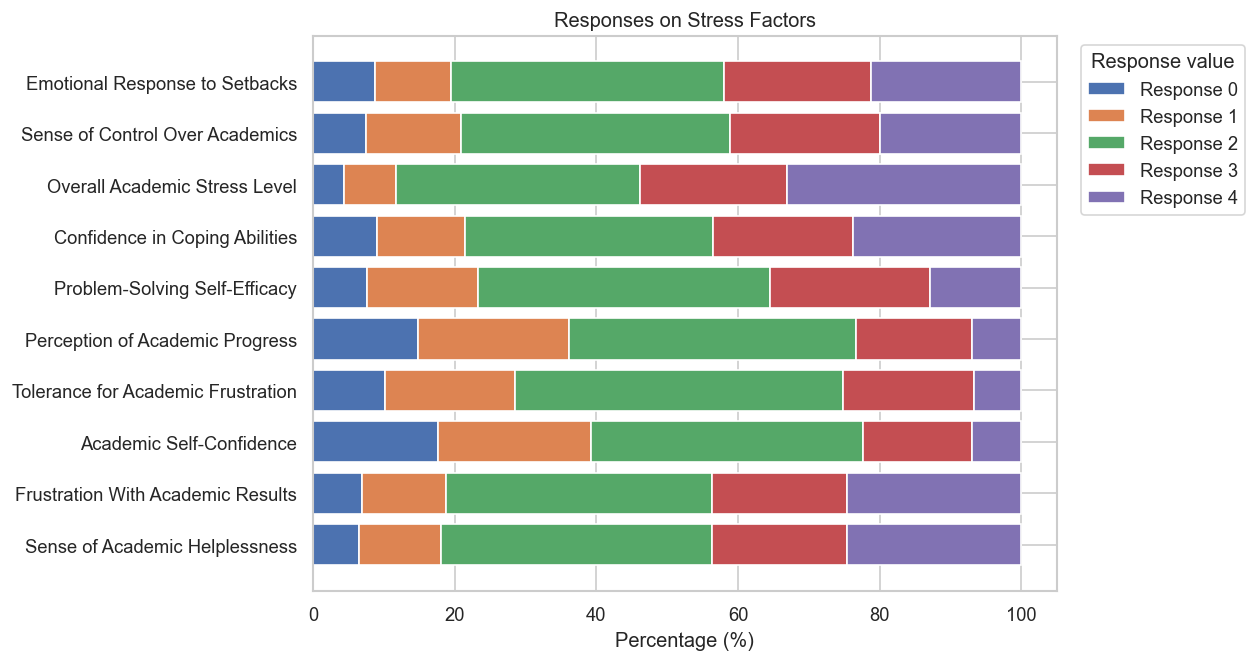

In [14]:
pss_labels = [
    "Emotional Response to Setbacks",
    "Sense of Control Over Academics",
    "Overall Academic Stress Level",
    "Confidence in Coping Abilities",
    "Problem-Solving Self-Efficacy",
    "Perception of Academic Progress",
    "Tolerance for Academic Frustration",
    "Academic Self-Confidence",
    "Frustration With Academic Results",
    "Sense of Academic Helplessness"
]

pss_pct = (df[pss_cols].apply(lambda col: col.value_counts(normalize=True).sort_index()) * 100).fillna(0)
for val in [0,1,2,3,4]:
    if val not in pss_pct.index:
        pss_pct.loc[val] = 0
pss_pct = pss_pct.sort_index()

pss_pct_t = pss_pct.T[sorted(pss_pct.index)].reindex(pss_cols)
pss_pct_t.index = pss_labels

fig, ax = plt.subplots(figsize=(8,6))
bottom = np.zeros(len(pss_pct_t))
for col in pss_pct_t.columns:
    vals = pss_pct_t[col].values
    ax.barh(pss_pct_t.index, vals, left=bottom)
    bottom += vals
ax.set_xlabel("Percentage (%)")
ax.set_title("Responses on Stress Factors")
ax.invert_yaxis()
ax.legend([f"Response {int(c)}" for c in pss_pct_t.columns], title="Response value", bbox_to_anchor=(1.02,1), loc="upper left")
save_fig(fig, "responses_pss_stress")
plt.show()

## Responses on Anxiety Factors

✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\responses_gad_anxiety.png


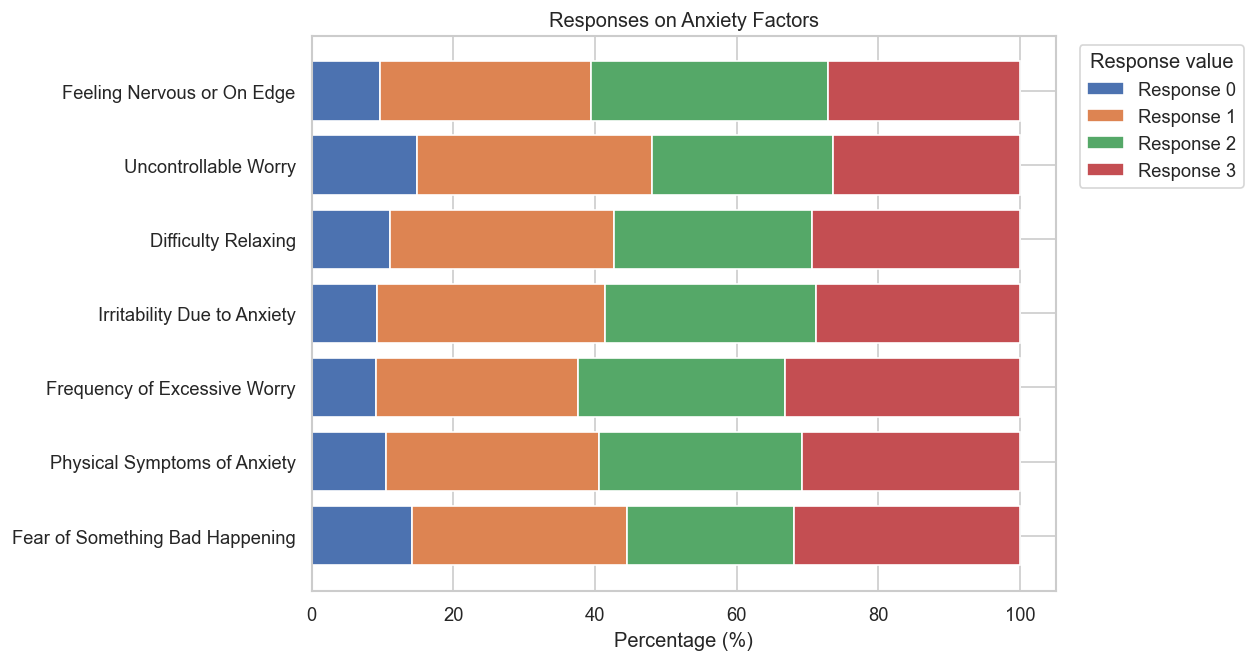

In [15]:
gad_labels = [
    "Feeling Nervous or On Edge",
    "Uncontrollable Worry",
    "Difficulty Relaxing",
    "Irritability Due to Anxiety",
    "Frequency of Excessive Worry",
    "Physical Symptoms of Anxiety",
    "Fear of Something Bad Happening"
]

gad_pct = (df[gad_cols].apply(lambda col: col.value_counts(normalize=True).sort_index()) * 100).fillna(0)
for val in [0,1,2,3]:
    if val not in gad_pct.index:
        gad_pct.loc[val] = 0
gad_pct = gad_pct.sort_index()
gad_pct_t = gad_pct.T[sorted(gad_pct.index)].reindex(gad_cols)
gad_pct_t.index = gad_labels

fig, ax = plt.subplots(figsize=(8,6))
bottom = np.zeros(len(gad_pct_t))
for col in gad_pct_t.columns:
    vals = gad_pct_t[col].values
    ax.barh(gad_pct_t.index, vals, left=bottom)
    bottom += vals
ax.set_xlabel("Percentage (%)")
ax.set_title("Responses on Anxiety Factors")
ax.invert_yaxis()
ax.legend([f"Response {int(c)}" for c in gad_pct_t.columns], title="Response value", bbox_to_anchor=(1.02,1), loc="upper left")
save_fig(fig, "responses_gad_anxiety")
plt.show()

## Responses on Depression Factors

✅ Figure saved: D:\Programming\Projects\Depression Severity Assessment\figures\Exploratory Data Analysis\responses_phq_depression.png


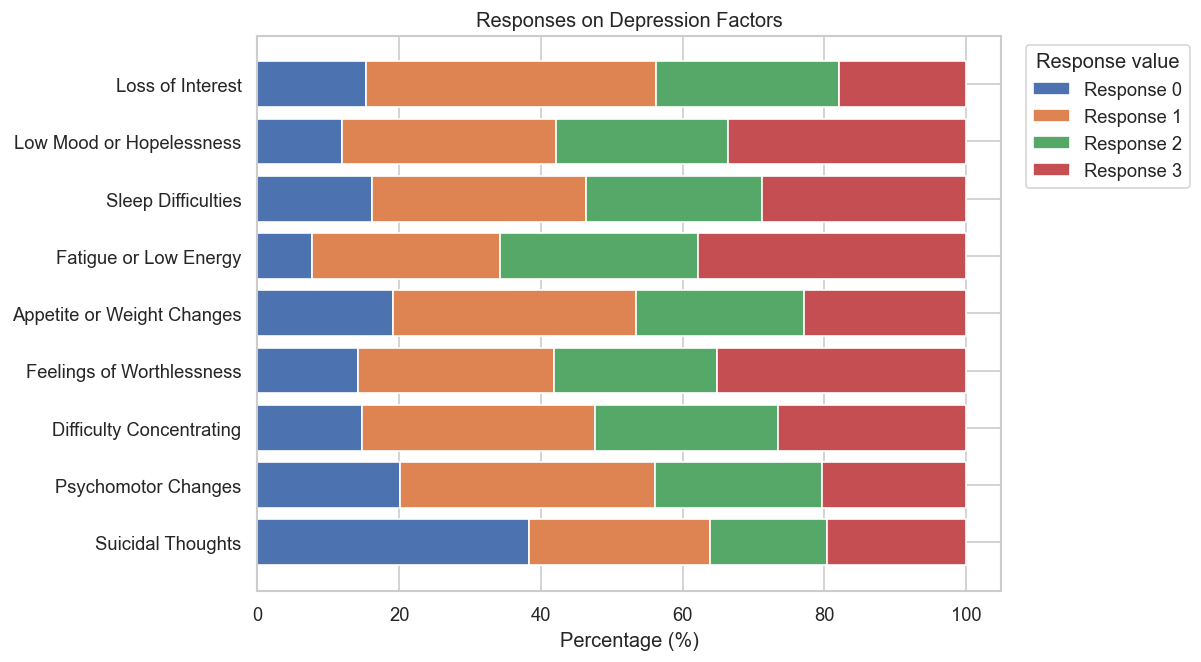

In [16]:
phq_cols = [f"PHQ{i+1}" for i in range(9)]
phq_rename = {
    "PHQ1": "Loss of Interest",
    "PHQ2": "Low Mood or Hopelessness",
    "PHQ3": "Sleep Difficulties",
    "PHQ4": "Fatigue or Low Energy",
    "PHQ5": "Appetite or Weight Changes",
    "PHQ6": "Feelings of Worthlessness",
    "PHQ7": "Difficulty Concentrating",
    "PHQ8": "Psychomotor Changes",
    "PHQ9": "Suicidal Thoughts"
}

phq_counts = df[phq_cols].apply(pd.Series.value_counts, normalize=True).fillna(0) * 100
phq_pct_t = phq_counts.T.rename(index=phq_rename)

fig, ax = plt.subplots(figsize=(8, 6))
bottom = np.zeros(len(phq_pct_t))
for col in phq_pct_t.columns:
    vals = phq_pct_t[col].values
    ax.barh(phq_pct_t.index, vals, left=bottom)
    bottom += vals

ax.set_xlabel("Percentage (%)")
ax.set_title("Responses on Depression Factors")
ax.invert_yaxis()
ax.legend([f"Response {int(c)}" for c in phq_pct_t.columns], title="Response value", bbox_to_anchor=(1.02, 1), loc="upper left")
save_fig(fig, "responses_phq_depression")
plt.show()